# Experiment Statistics

Dieses Notebook (percent script) kann mit Jupytext als Notebook geöffnet werden.


## Check connection to MLflow server

In [48]:
import os
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

from tempfile import TemporaryDirectory
import json5
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
# Erzwinge die Tracking-URI auf den MLflow-Container im Compose-Netz
TRACKING_HOST = 'mlflow'
TRACKING_PORT = os.getenv('MLFLOW_PORT')  # Fallback, falls nicht gesetzt
mlflow.set_tracking_uri(f'http://{TRACKING_HOST}:{TRACKING_PORT}')

print('Tracking URI (gesetzt):', mlflow.get_tracking_uri())
print('MLFLOW_TRACKING_URI (env):', os.getenv('MLFLOW_TRACKING_URI'))


Tracking URI (gesetzt): http://mlflow:5321
MLFLOW_TRACKING_URI (env): http://mlflow:5321


In [50]:
client = MlflowClient()  # nutzt die oben gesetzte Tracking-URI
experiments = client.search_experiments()
print('Experimente gefunden:', len(experiments))
for exp in experiments:
    print(f"- {exp.experiment_id}: {exp.name} (lifecycle_stage={exp.lifecycle_stage})")


Experimente gefunden: 14
- 13: Annotation Import (lifecycle_stage=active)
- 12: Double Transformation PoC 0.2 (lifecycle_stage=active)
- 11: Double Transformation PoC (lifecycle_stage=active)
- 10: PoC Image Degrading 0.8 (lifecycle_stage=active)
- 9: PoC Image Degrading 0.7 (lifecycle_stage=active)
- 8: PoC Image Scoring 0.6 (lifecycle_stage=active)
- 7: PoC Image Degrading 0.6 (lifecycle_stage=active)
- 6: PoC Image Defrading 0.6 (lifecycle_stage=active)
- 5: PoC Image Degrading 0.1 (lifecycle_stage=active)
- 4: PoC Image Scoring 0.3 (lifecycle_stage=active)
- 3: PoC Image Scoring 0.2 (lifecycle_stage=active)
- 2: PoC Image Scoring 0.1 (lifecycle_stage=active)
- 1: API_Poc_0.2 (lifecycle_stage=active)
- 0: Default (lifecycle_stage=active)


## Select Experiment and show runs

In [60]:
experiment_id = '13'

In [61]:
experiment = client.get_experiment(experiment_id)
experiment_name = experiment.name

if experiment is None:
    raise ValueError(f"Experiment with id '{experiment_id}' not found – please check your experiment ID.")

runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string='',
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=20,
    order_by=['attributes.start_time DESC'],
)

print(f"Found runs in '{experiment_name}': {len(runs)}")
for r in runs:
    #print(r.info.run_id, r.data.params, r.data.metrics)
    print(r.info.run_id)

Found runs in 'Annotation Import': 1
b3700a8db660422389dae0d6efa0bb67


## Select run (id or last run of selected experiment)

In [62]:
run_id = ''
run = None

if not runs and run_id == '':
    raise ValueError('No run id selected or no runs found. Please select a run or another experiment.')

if run_id != '':
    run = client.get_run(run_id)
else:
    run = runs[0]

if run is None:
    raise ValueError('No run selected. Please select a run or another experiment.')

print(run.info.run_name, run.info.run_id, run.data.params, run.data.metrics)

trusting-shoat-472 b3700a8db660422389dae0d6efa0bb67 {'annotation_file_path': '_annotation_uploads/annotations.json', 'annotation_file_size_bytes': '17034818', 'annotation_file_name': 'annotations.json'} {'upload_success': 1.0, 'experiment_duration_seconds': 0.47128212499956135}


### Show list of artifacts for the selected run

In [64]:
print("artifact_uri:", run.info.artifact_uri)

# # Erstdiagnose: direkte Root-Listings mit verschiedenen Root-Werten
# try:
#     root_none = client.list_artifacts(run.info.run_id, None)
# except TypeError:
#     # Ältere MLflow-Clients erlauben None nicht – dann ignorieren
#     root_none = []
# root_empty = client.list_artifacts(run.info.run_id, "")
# root_dot = client.list_artifacts(run.info.run_id, ".")
#
# print("Root listing sizes → None:", len(root_none), "| '':", len(root_empty), "| '.':", len(root_dot))
# if not root_none and not root_empty and not root_dot:
#     print("Hinweis: Der Server liefert für die Wurzel keine Einträge zurück. Wir versuchen dennoch Rekursion.")

def list_artifacts_recursive(client: MlflowClient, run_id: str, path = None, depth: int = 0) -> None:
    """Listet Artefakte rekursiv, beginnend bei `path` (None/''/'.' = Wurzel)."""
    try:
        items = client.list_artifacts(run_id, path)
    except TypeError:
        # Fallback für Clients, die None nicht akzeptieren
        items = client.list_artifacts(run_id, path or "")
    if not items and depth == 0:
        print("(keine Artefakte gefunden am Wurzelpfad)")
    for item in items:
        prefix = "  " * depth
        print(f"{prefix}{'DIR ' if item.is_dir else 'FILE'} {item.path}")
        if item.is_dir:
            list_artifacts_recursive(client, run_id, item.path, depth + 1)

# Auflisten ab der Wurzel (None → robust für verschiedene Client-Versionen)
list_artifacts_recursive(client, run.info.run_id, None)

# Zusatztest: Versuche gezielt eine Datei am Wurzelpfad zu laden, z. B. annotations.json
# from tempfile import TemporaryDirectory
# candidate_file = "annotations.json"
# try:
#     with TemporaryDirectory() as td:
#         lp = client.download_artifacts(run.info.run_id, candidate_file, dst_path=td)
#         print(f"Download ok: {candidate_file} →", lp)
# except Exception as e:
#     print(f"Download fehlgeschlagen für {candidate_file}:", e)

artifact_uri: /mlruns/13/b3700a8db660422389dae0d6efa0bb67/artifacts
FILE annotations.json


## Prepare data from annotations.json fiel for further processing

### Load annotations.json from artifacts

In [65]:
filename = 'annotations.json'
data = None

def load_annotations_json5(path: str | Path) -> dict:
    return json5.load(open(path, "r", encoding="utf-8"))

with TemporaryDirectory() as temporary_directory:
    local_path = client.download_artifacts(run.info.run_id, filename, dst_path=temporary_directory)
    path = Path(local_path)
    data = load_annotations_json5(path)
    print(f"Loaded annotations from {path}")

if run is None:
    raise ValueError('No data loaded. Please select a run or another experiment.')

Loaded annotations from /tmp/tmp644t59md/annotations.json


### Convert to pandas dataFrames

In [81]:
def coco_to_dataframes(data: dict):
    images_df = pd.DataFrame(data.get("images", []))
    annotations_df = pd.DataFrame(data.get("annotations", []))
    categories_df = pd.DataFrame(data.get("categories", []))
    all_data_df = annotations_df

    # Calculate score difference between initial and final score
    all_data_df["score_diff"] = all_data_df.score - all_data_df.initial_score

    # Add category names to annotations
    if not categories_df.empty:
        cat_df = categories_df.rename(columns={"id": "category_id", "name": "category_name"})
        all_data_df = all_data_df.merge(cat_df[["category_id", "category_name"]], on="category_id", how="left")

    # Add image information to annotations
    if not images_df.empty:
        im_df = images_df.rename(columns={"id": "image_id", "file_name": "image_file"})
        all_data_df = all_data_df.merge(im_df[["image_id", "image_file", "width", "height"]], on="image_id", how="left")


    all_data_df['transformation'] = all_data_df['transformation'].fillna('all transformation')
    all_data_df['sequence'] = all_data_df['sequence'].fillna(0)

    # Filter out annotations with no score. At the moment there is no second transformation.
    #all_data_df = all_data_df[~all_data_df.score.isna()]

    return all_data_df, annotations_df, images_df, categories_df

all_data_data_frame, annotations_data_frame, images_data_frame, categories_data_frame = coco_to_dataframes(data)
print(all_data_data_frame.head())


   id  image_id  category_id bbox  area  iscrowd segmentation  sequence  \
0   1         1            2   []     0        0           []       1.0   
1   2         1            3   []     0        0           []       2.0   
2   3         1            0   []     0        0           []       0.0   
3   4         2            2   []     0        0           []       1.0   
4   5         2            4   []     0        0           []       2.0   

     score  initial_score      transformation  score_diff category_name  \
0  5.12500         6.1875          CA_SWAP_GB    -1.06250    CA_SWAP_GB   
1  5.06250         5.1250          CA_SWAP_RB    -0.06250    CA_SWAP_RB   
2  5.06250         6.1875  all transformation    -1.12500           NaN   
3  5.12500         6.1875          CA_SWAP_GB    -1.06250    CA_SWAP_GB   
4  5.46875         5.1250          CA_SWAP_RG     0.34375    CA_SWAP_RG   

                                          image_file  width  height  
0  0878__CA_SWAP_GB__CA_SWAP

## Auswertungen

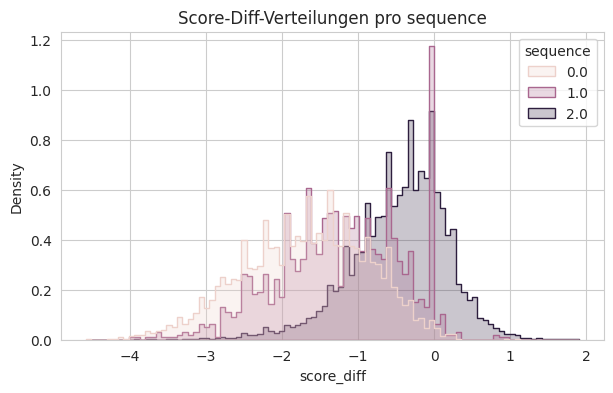

In [79]:
# Beispiel 1: Score-Verteilung nach Sequenz
plt.figure(figsize=(7,4))
sns.histplot(data=all_data_data_frame, x="score_diff", hue="sequence", element="step", stat="density", common_norm=False)
plt.title("Score-Diff-Verteilungen pro sequence")
plt.show()

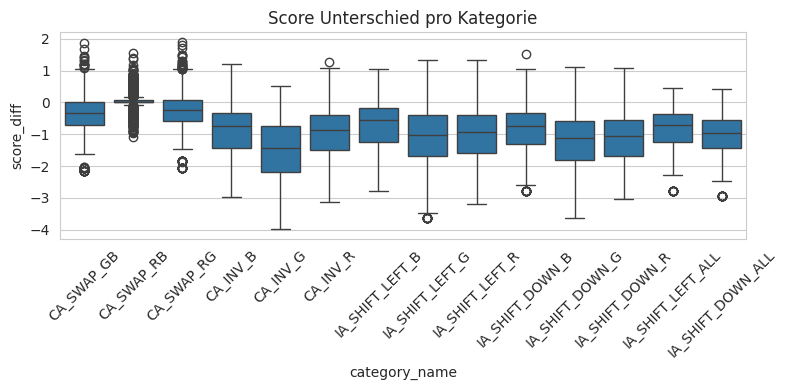

In [76]:
# Beispiel 2: Boxen nach Kategorie (Transformation)
plt.figure(figsize=(8,4))
sns.boxplot(data=all_data_data_frame, x="category_name", y="score_diff")
plt.xticks(rotation=45)
plt.title("Score Unterschied pro Kategorie")
plt.tight_layout()
plt.show()

<Figure size 1600x1400 with 0 Axes>

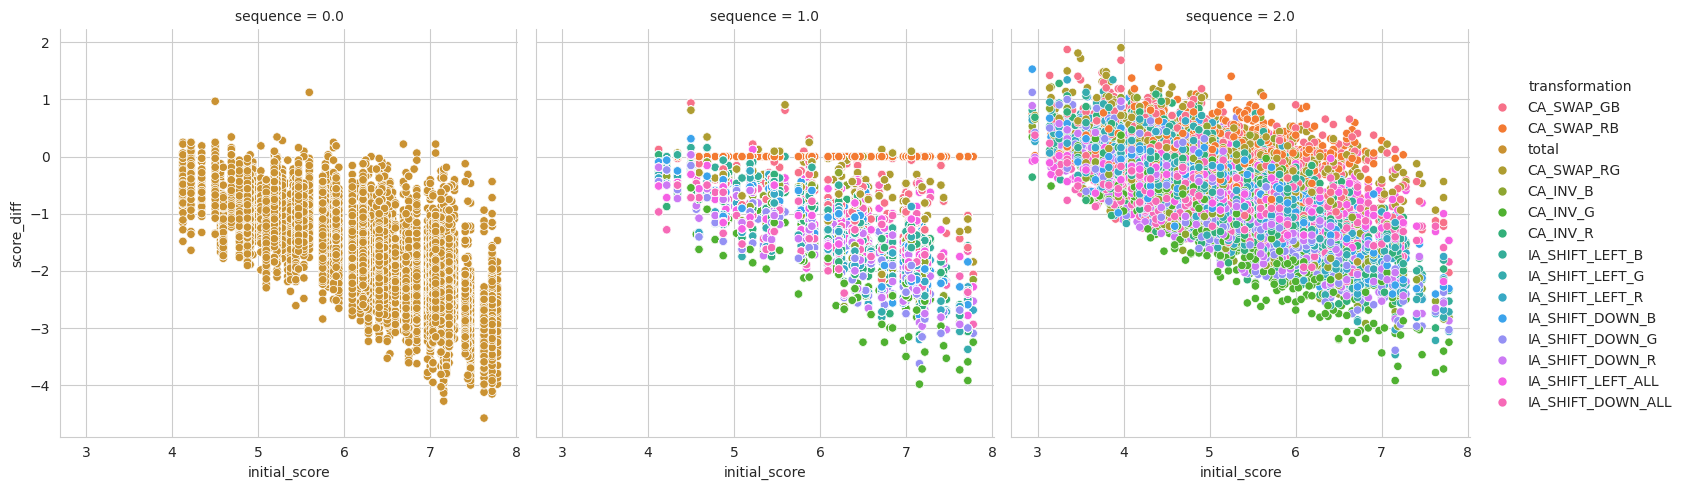

In [80]:
plt.figure(figsize=(16,14))
# sns.scatterplot(x="initial_score",
#                 y="score_diff",
#                 hue="transformation",
#                 style="sequence",
#                 data=annotations_data_frame)

sns.relplot(
    data=all_data_data_frame, x="initial_score", y="score_diff",
    col="sequence", hue="transformation",
    kind="scatter"
)

plt.show()

<Figure size 1600x1400 with 0 Axes>

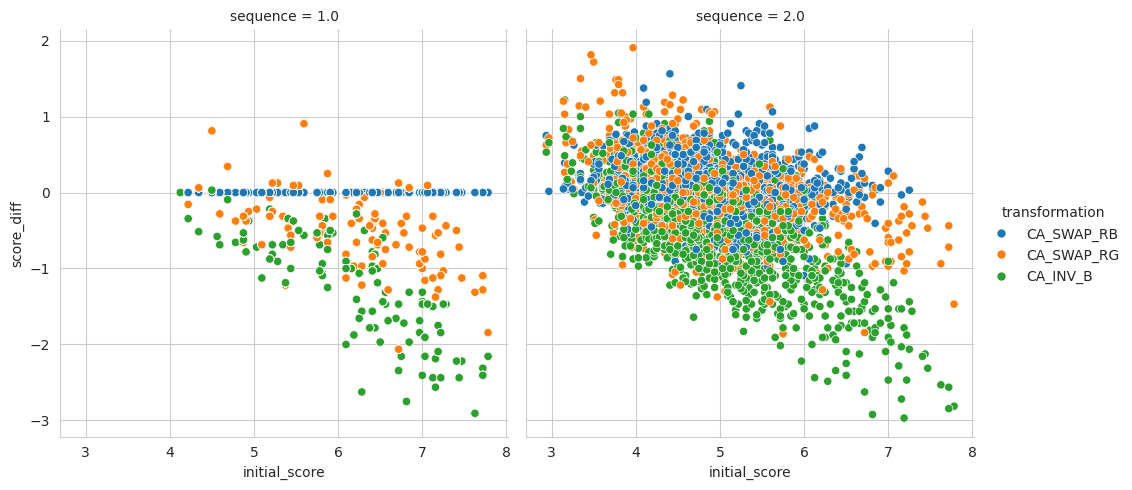

In [84]:
plt.figure(figsize=(16,14))
filtered_data = all_data_data_frame[all_data_data_frame['transformation'].isin(['CA_SWAP_RB', 'CA_SWAP_RG', 'CA_INV_B'])]

sns.relplot(
    data=filtered_data, x="initial_score", y="score_diff",
    col="sequence", hue="transformation",
    kind="scatter"
)

plt.show()